# pix2pix in Tensorflow
The original repo can be found [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md).
Dataset That will be used: [facades](http://cmp.felk.cvut.cz/~tylecr1/facade/)

## preparation
Please download and unzip the [dataset](http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip) into the directory `./dataset/` before running!


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Load images

In [2]:
images = []
labels = []

import glob
from PIL import Image

path = "dataset/base/"

for image_path in glob.glob(path + "*.png"):
    img = Image.open(image_path)
    img = img.resize((200, 200))
    images.append(np.array(img.getdata()).reshape((200, 200)))

    lbl = Image.open(image_path.replace(".png", ".jpg"))
    lbl = lbl.resize((200, 200))
    labels.append(np.array(lbl.getdata()).reshape((200, 200, 3)))

#### Visualization of random images and their labels

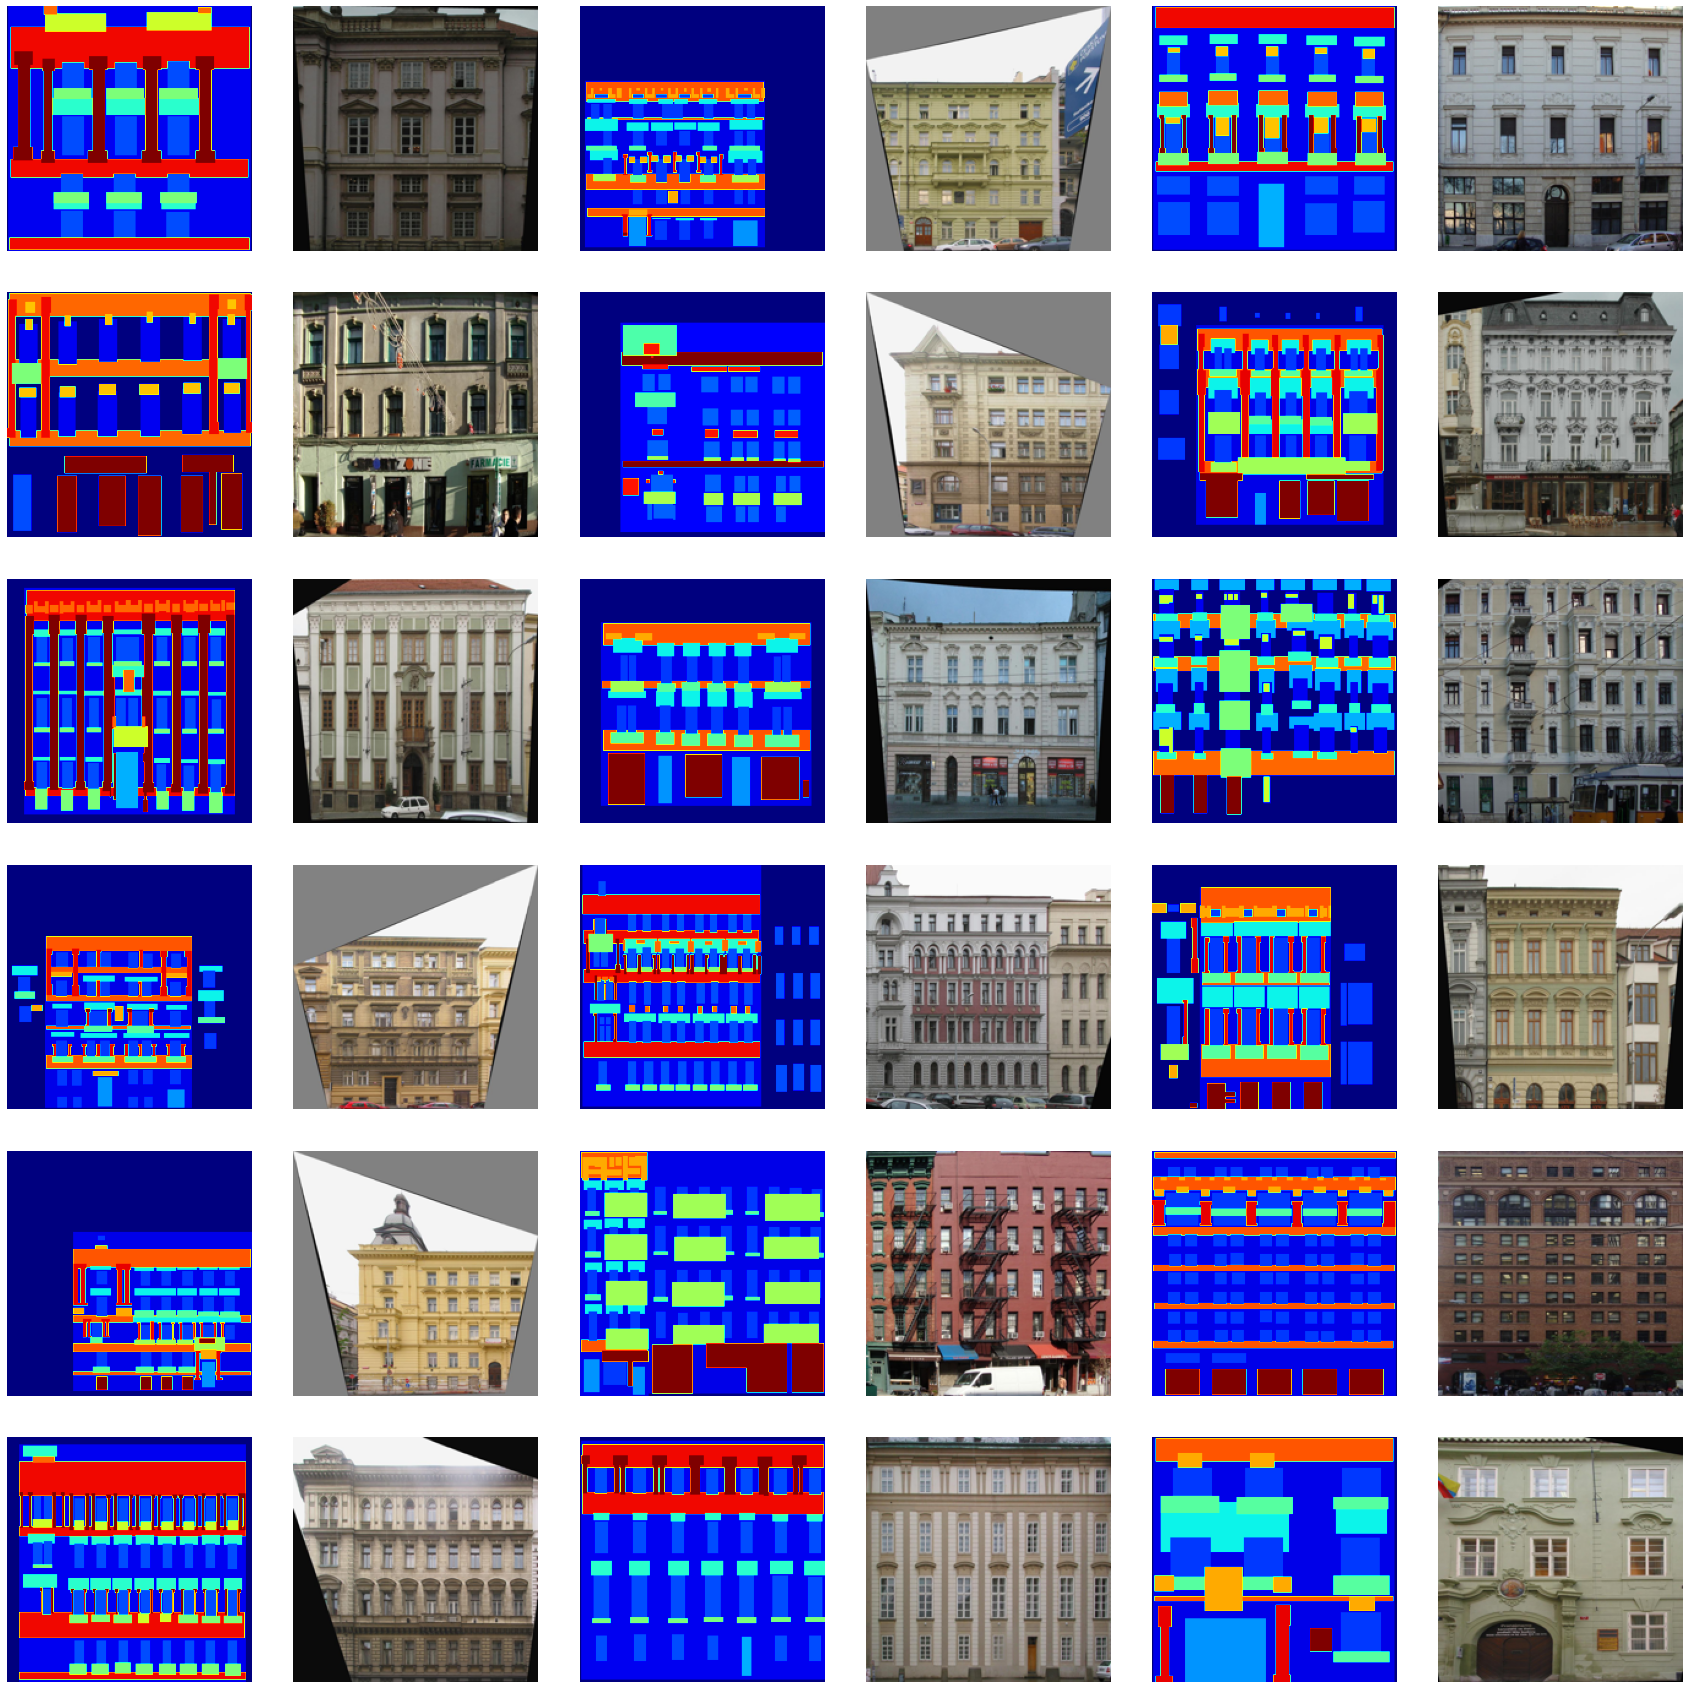

In [3]:
%matplotlib inline
fig, ax = plt.subplots(6,6,figsize=(24,24))
fig.tight_layout()
ax = ax.flatten()
for i in range(18):
    rand = np.random.randint(len(images)-1)
    img = images[rand]
    lbl = labels[rand]
    
    ax[2 * i].imshow(img, cmap='jet')
    ax[2 * i].axis("off")
    ax[2 * i + 1].imshow(lbl)
    ax[2 * i + 1].axis("off")

## Split dataset into train and test

In [4]:
import math
num_test = math.floor(len(images) * 0.1)

test_images = np.array(images[:num_test], dtype=np.float32)
test_labels = np.array(labels[:num_test], dtype=np.float32)

train_images = np.array(images[num_test:], dtype=np.float32)
train_labels = np.array(labels[num_test:], dtype=np.float32)

## Generate tf datasets

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=50000)
batch_size = 64
train_dataset = train_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(10000)